## __Ikea Image Classifier__

Perform the classification using machine learning technique(for eg. CNNs). The model should be able to predict the class label of an image. 

For extracting images I have used Beautiful Soup. The python program and notebook can be found on my github account: https://github.com/rratnakar09/ikea_image_classifier

I have used os module and opencv to read and display the image. 

In [1]:
# import the required packages
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


## Load the images

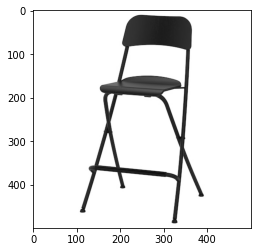

In [2]:
DATADIR = "../input/dataset"
CATEGORIES = ["chair", "table", "tv_storage", "wardrobes"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) # path to different images folder
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array, cmap='gray')
        break
    break   

In [3]:
# let's check the shape of an image
print(img_array.shape)

(500, 500, 3)


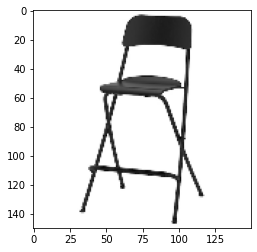

In [4]:
# Images can be of different shape and size so, we will resize all the images to make the size 
# uniform across all the images
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [5]:
new_array.shape

(150, 150, 3)

In [6]:
# create the data set for chair, table, tv_storage, wardrobes and store them in training list
image_data = []
# create a image_count lis which will store the image count for every categories.
image_count=[] 
def create_data():
    for category in CATEGORIES:
        count=0
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                # img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                image_data.append([new_array, class_num])
                count += 1
            except:
                pass
        image_count.append(count)    

# call the create_data function to read all the images, create a label based on sub directory(categories of image)
# and storethem in a list
create_data()            

In [7]:
image_data[1][0].shape

(150, 150, 3)

In [8]:
# let's view the images count for different categories
image_count

[24, 24, 24, 24]

We have a total of 96 images with 24 images each of all foure catrgories. We will dvide training and testing data into 80%, 20%. Training data will have 20 images from each categories and testing data will have 4 images from each categories.

In [9]:
count=0
training_data = []
validation_data = []
testing_data = []
for i in range(4):
    for j in range(count, count+16):
        training_data.append(image_data[j])
    count += 16
    
    for k in range(count, count+4):
        validation_data.append(image_data[k])
    count += 4 
    
    for l in range(count, count+4):
        testing_data.append(image_data[l])
    count += 4 
    
    print(count)

24
48
72
96


In [10]:
# Check the image count of training and testing data set
len(training_data), len(validation_data), len(testing_data)

(64, 16, 16)

Here as images was read based on one categories at a time so we will suffle the data and mix them randomly

In [11]:
# suffle the data to mix up the data
import random
random.shuffle(training_data)
random.shuffle(validation_data)
random.shuffle(testing_data)

In [12]:
# check the image lable for some images of training data
for sample in training_data[:10]:
    print(sample[1])    

0
0
1
1
3
1
1
1
3
3


In [13]:
# check the image lable for some images of testing data
for sample in testing_data[:10]:
    print(sample[1])

3
2
2
2
3
0
1
3
0
1


In [14]:
# split the image data and image label for train, valid, test data set
def prep_data(images):
    
    X = [] # for features
    y = [] # for labels
    
    for features, label in images:
        X.append(features)
        y.append(label)
    
    X = np.array(X).reshape(-1, IMG_SIZE,IMG_SIZE, 3)
    
    # Normalize the  data
    X = X/255.0
    
    return X, y

In [15]:
# call prep_data() by passing training_data to build training data set 
X_train , y_train = prep_data(training_data)

# call prep_data() by passing validation_data to build validation data set 
X_valid , y_valid = prep_data(validation_data)

# call prep_data() by passing testing_data to build testing data set 
X_test , y_test = prep_data(testing_data)

In [16]:
# Label encoding
# Labels are 4 digits numbers from 0 to 3. We need to encode these lables to one hot vectors 
# (ex : for label 2 -> [0,0,1,0]).
y_train = to_categorical(y_train, num_classes = 4)
y_valid = to_categorical(y_valid, num_classes = 4)

## Build a base CNN model

In [17]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)            

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
# compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_valid, y_valid))

Train on 64 samples, validate on 16 samples
Epoch 1/50
64/64 [==============================] - 4s 68ms/step - loss: 14.3502 - accuracy: 0.3125 - val_loss: 1.3146 - val_accuracy: 0.5000
Epoch 2/50
64/64 [==============================] - 0s 2ms/step - loss: 1.5502 - accuracy: 0.3438 - val_loss: 1.1760 - val_accuracy: 0.4375
Epoch 3/50
64/64 [==============================] - 0s 2ms/step - loss: 1.2406 - accuracy: 0.5156 - val_loss: 0.8865 - val_accuracy: 0.8750
Epoch 4/50
64/64 [==============================] - 0s 2ms/step - loss: 1.5064 - accuracy: 0.5000 - val_loss: 1.4022 - val_accuracy: 0.5625
Epoch 5/50
64/64 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.6406 - val_loss: 1.3932 - val_accuracy: 0.6875
Epoch 6/50
64/64 [==============================] - 0s 2ms/step - loss: 0.8345 - accuracy: 0.6719 - val_loss: 2.7372 - val_accuracy: 0.6875
Epoch 7/50
64/64 [==============================] - 0s 2ms/step - loss: 1.1153 - accuracy: 0.6562 - val_loss: 1.58

### Let's plot the loss and accuracy of the model over the training and validation data during training:

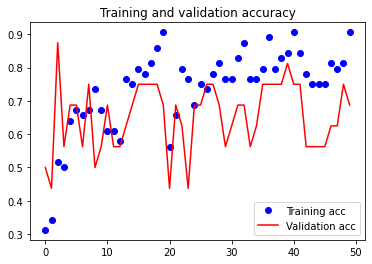

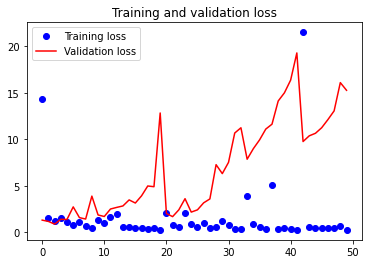

In [22]:
# plot the loss and accuracy of the model 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# predict the labels probability of test images
predictions = model.predict(X_test)

# argmax will choose the value having max probability
model_res = np.argmax(predictions, axis=1)

true_pred = 0
false_pred = 0
for i in range(len(y_test)):
    if y_test[i] == model_res[i]:
        true_pred += 1
    else:
        false_pred +=1
print(true_pred, false_pred) 

test_score = (true_pred /(true_pred+false_pred)) * 100
print("Test score", str(test_score) + '%')

10 6
Test score 62.5%


## Build the model with droupout 

In [24]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

In [25]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# learning rate annealing or adaptive learning rates which is used to update network weights for 
# each training epoch.
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_valid, y_valid),
                   callbacks=[learning_rate_reduction])

Train on 64 samples, validate on 16 samples
Epoch 1/50
64/64 [==============================] - 1s 9ms/step - loss: 15.3868 - accuracy: 0.3906 - val_loss: 1.3826 - val_accuracy: 0.3125
Epoch 2/50
64/64 [==============================] - 0s 2ms/step - loss: 1.4008 - accuracy: 0.3438 - val_loss: 1.3194 - val_accuracy: 0.5625
Epoch 3/50
64/64 [==============================] - 0s 2ms/step - loss: 1.3011 - accuracy: 0.4531 - val_loss: 1.2652 - val_accuracy: 0.6250
Epoch 4/50
64/64 [==============================] - 0s 2ms/step - loss: 1.1133 - accuracy: 0.4531 - val_loss: 1.0855 - val_accuracy: 0.6875
Epoch 5/50
64/64 [==============================] - 0s 2ms/step - loss: 1.1759 - accuracy: 0.4844 - val_loss: 1.0858 - val_accuracy: 0.5000
Epoch 6/50
64/64 [==============================] - 0s 2ms/step - loss: 0.9053 - accuracy: 0.6094 - val_loss: 1.1006 - val_accuracy: 0.6250
Epoch 7/50
64/64 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.7500 - val_loss: 1.168

### Let's plot the loss and accuracy of the model over the training and validation data during training:

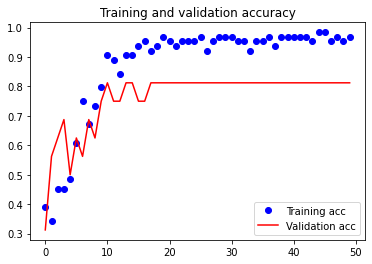

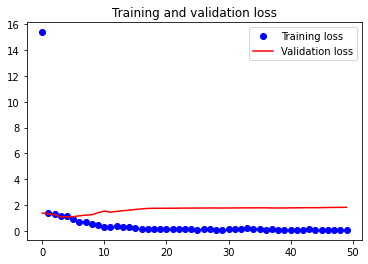

In [28]:
# plot the loss and accuracy of the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# predict the labels probability of test images
predictions = model.predict(X_test)
# argmax will choose the value having max probability
model_res = np.argmax(predictions, axis=1)
true_pred = 0
false_pred = 0
for i in range(len(y_test)):
    if y_test[i] == model_res[i]:
        true_pred += 1
    else:
        false_pred +=1
print(true_pred, false_pred)        
test_score = (true_pred /(true_pred+false_pred)) * 100
print("Test score", str(test_score) + '%')

13 3
Test score 81.25%


__Data augmentation__

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

* Without data augmentation i obtained an accuracy of 93.75%
* With data augmentation i achieved 87.5% of accuracy

In [30]:
# Create a instance of ImageDataGenerator class
# use random value between 100 and 120 to select channel shift value
#import random 
#ch_shift = random.randrange(150, 200)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest')

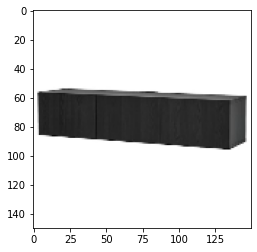

In [31]:
# lets view a image, we will use this image to see how data agumentation works
from keras.preprocessing import image

plt.imshow(image.array_to_img(X_train[45]))
plt.show() 

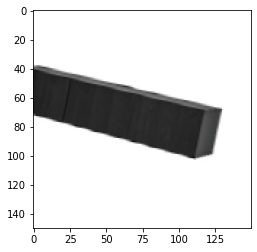

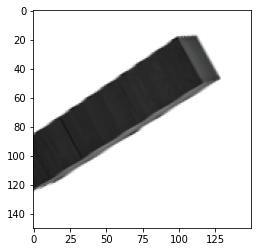

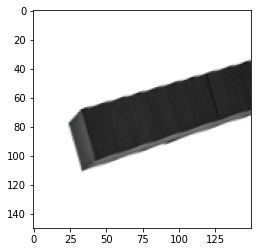

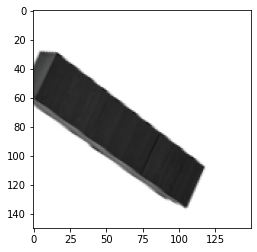

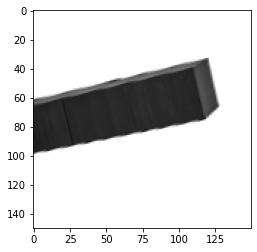

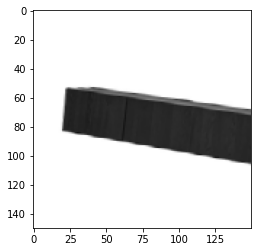

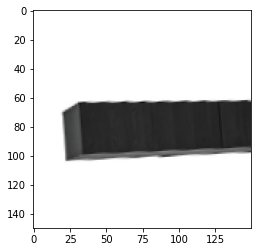

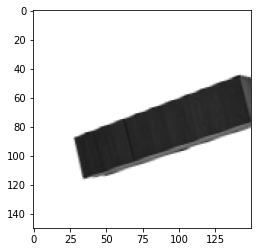

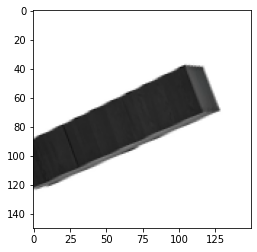

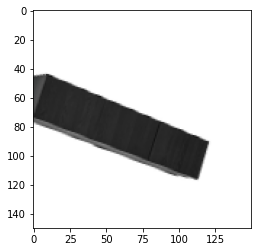

In [32]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!

# test with one image
x = X_train[45]

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 10 == 0:
        break

plt.show()

# Build a CNN model with droupout

In [33]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

In [34]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [35]:
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                              steps_per_epoch=len(X_train) / 16, 
                              epochs=50, 
                              validation_data=(X_valid, y_valid),
                              callbacks=[learning_rate_reduction])

Epoch 1/50
4/4 [==============================] - 1s 201ms/step - loss: 12.4120 - accuracy: 0.2344 - val_loss: 1.3742 - val_accuracy: 0.2500
Epoch 2/50
4/4 [==============================] - 0s 83ms/step - loss: 1.4955 - accuracy: 0.3125 - val_loss: 1.3844 - val_accuracy: 0.3750
Epoch 3/50
4/4 [==============================] - 0s 92ms/step - loss: 1.3934 - accuracy: 0.2188 - val_loss: 1.3762 - val_accuracy: 0.3125
Epoch 4/50
4/4 [==============================] - 0s 97ms/step - loss: 1.3664 - accuracy: 0.3281 - val_loss: 1.3261 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 0s 99ms/step - loss: 1.3085 - accuracy: 0.3281 - val_loss: 1.2077 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 0s 98ms/step - loss: 1.7175 - accuracy: 0.2344 - val_loss: 1.3916 - val_accuracy: 0.4375
Epoch 7/50
4/4 [==============================] - 0s 98ms/step - loss: 1.3889 - accuracy: 0.2344 - val_loss: 1.3409 - val_accuracy: 0.2500
Epoch 8/50
4/4 [=========

### Let's plot the loss and accuracy of the model over the training and validation data during training:

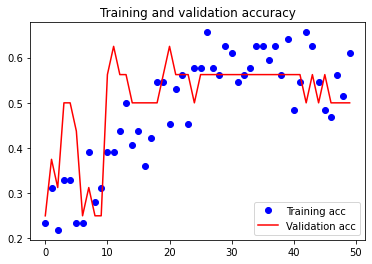

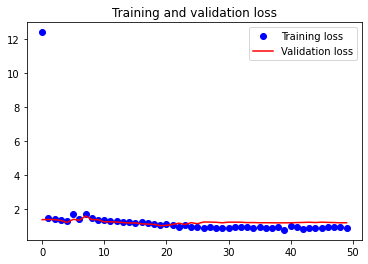

In [36]:
# plot the loss and accuracy of the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
# predict the labels probability of test images
predictions = model.predict(X_test)
# argmax will choose the value having max probability
model_res = np.argmax(predictions, axis=1)
true_pred = 0
false_pred = 0
for i in range(len(y_test)):
    if y_test[i] == model_res[i]:
        true_pred += 1
    else:
        false_pred +=1
print(true_pred, false_pred)        
test_score = (true_pred /(true_pred+false_pred)) * 100
print("Test score", str(test_score) + '%')

8 8
Test score 50.0%
